In [ ]:
pip install pydicom nibabel numpy torch torchvision segmentation-models-pytorch scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install albumentations

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import numpy as np
import pydicom
import nibabel as nib
import torch
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import pandas as pd
import random
import segmentation_models_pytorch as smp
import torch.optim as optim
import torch.nn as nn
from scipy.ndimage import zoom
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
from operator import itemgetter

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

num_classes = 9
batch_size = 8
img_root = "/home/ealam/JHIR_Hip_Knee_Datasets/Knee/Images"
mask_root = "/home/ealam/JHIR_Hip_Knee_Datasets/Knee/Annotations"
metadata_path = "/home/ealam/JHIR_Hip_Knee_Datasets/Knee/segmentation_with_racegender.csv"
test_augmentations = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2(),
])

class MulticlassHipSegmentationDataset(Dataset):
    def __init__(self, img_root, mask_root, metadata_df, paired_files, num_classes, transforms=None, preprocessing=None):
        self.img_root = img_root
        self.mask_root = mask_root
        self.metadata_df = metadata_df
        self.paired_files = paired_files
        self.num_classes = num_classes
        self.transforms = transforms
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.paired_files)

    def __getitem__(self, idx):
        img_name, mask_name = self.paired_files[idx]

        dicom_image = pydicom.dcmread(os.path.join(self.img_root, img_name))
        image = dicom_image.pixel_array.astype(np.float32)
        annotation = nib.load(os.path.join(self.mask_root, mask_name))
        annotation_data = annotation.get_fdata()
        if len(annotation_data.shape) == 3:
            annotation_data = annotation_data[:, :, 0]

        annotation_data = self.calculate_flipped_rotated_mask(annotation_data)

        if annotation_data.ndim > 2 and annotation_data.shape[-1] != 1:
            raise ValueError('Mask has multiple channels')

        if image.shape != annotation_data.shape:
            zoom_factors = np.array(image.shape) / np.array(annotation_data.shape)
            annotation_data = zoom(annotation_data, zoom_factors, order=0)

        if self.transforms is not None:
            transformed = self.transforms(image=image, mask=annotation_data)
            image = transformed["image"]
            annotation_data = transformed["mask"]

        annotation_data_onehot = self.one_hot_encode(annotation_data)

        if self.preprocessing is not None:
            transformed = self.preprocessing(image=image, mask=annotation_data_onehot)
            image = transformed["image"]
            annotation_data_onehot = transformed["mask"]

        return image, annotation_data_onehot

    def one_hot_encode(self, mask):
        one_hot_mask = np.zeros((self.num_classes, *mask.shape), dtype=np.float32)
        for class_idx in range(self.num_classes):
            one_hot_mask[class_idx][mask == class_idx] = 1.0
        return one_hot_mask

    def calculate_flipped_rotated_mask(self, mask):
        rotated_mask = cv2.rotate(mask, cv2.ROTATE_90_CLOCKWISE)
        flipped_rotated_mask = cv2.flip(rotated_mask, 1)
        return flipped_rotated_mask

metadata_df = pd.read_csv(metadata_path)

image_files = sorted(os.listdir(img_root))
mask_files = sorted(os.listdir(mask_root))

# Pair files based on imageid
paired_files = []
for img_file in image_files:
    img_id = os.path.splitext(img_file)[0]
    mask_file = f"{img_id}.nii.gz"
    if mask_file in mask_files:
        paired_files.append((img_file, mask_file))

random.shuffle(paired_files)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_size = int(0.7 * len(paired_files))
valid_size = int(0.1 * len(paired_files))
test_size = len(paired_files) - train_size - valid_size

train_pairs = paired_files[:train_size]
valid_pairs = paired_files[train_size:train_size + valid_size]
test_pairs = paired_files[train_size + valid_size:]

train_set = MulticlassHipSegmentationDataset(
    img_root, mask_root, metadata_df, train_pairs, num_classes,
    transforms=test_augmentations
)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

# Teacher model training
teacher_model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=1,
    classes=num_classes,
)
teacher_model.to(device)

optimizer = optim.Adam(teacher_model.parameters(), lr=0.0001, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
tepoch = 80
for epoch in range(tepoch):
    teacher_model.train()
    train_iou_list = []
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = teacher_model(images)
        predicted_masks = torch.argmax(outputs, dim=1)

        train_iou = jaccard_score(
            masks.argmax(dim=1).cpu().numpy().flatten(),
            predicted_masks.cpu().numpy().flatten(),
            average='micro'
        )
        train_iou_list.append(train_iou)

        loss = criterion(outputs, masks.argmax(dim=1))
        loss.backward()
        optimizer.step()

    mean_train_iou = np.mean(train_iou_list)
    print(f"Teacher Epoch [{epoch+1}/{tepoch}], Train IoU: {mean_train_iou:.4f}")

# Save the trained teacher model
torch.save(teacher_model.state_dict(), "trained_teacher_model.pth")

# Student model training using knowledge distillation
teacher_model.load_state_dict(torch.load("trained_teacher_model.pth"))
teacher_model.to(device)

student_model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=1,
    classes=num_classes,
)
student_model.to(device)

optimizer = optim.Adam(student_model.parameters(), lr=0.0001, weight_decay=1e-5)

iou_diffs = []
sepoch=100
for epoch in range(sepoch):
    student_model.train()
    iou_scores = []
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = student_model(images)
        loss = criterion(outputs, masks.argmax(dim=1))
        loss.backward()
        optimizer.step()

        # Calculate IoU for teacher and student
        with torch.no_grad():
            teacher_outputs = teacher_model(images)
            teacher_predicted_masks = torch.argmax(teacher_outputs, dim=1)
            teacher_iou = jaccard_score(
                masks.argmax(dim=1).cpu().numpy().flatten(),
                teacher_predicted_masks.cpu().numpy().flatten(),
                average='micro'
            )

            student_predicted_masks = torch.argmax(outputs, dim=1)
            student_iou = jaccard_score(
                masks.argmax(dim=1).cpu().numpy().flatten(),
                student_predicted_masks.cpu().numpy().flatten(),
                average='micro'
            )

            # Calculate the difference and store it
            iou_diff = teacher_iou - student_iou
            iou_diffs.append((iou_diff, images, masks, student_predicted_masks))

            iou_scores.append(student_iou)

    avg_iou = np.mean(iou_scores)
    print(f"Student Epoch [{epoch+1}/{sepoch}, Train IoU: {avg_iou:.4f}")

# Sort the dataset based on IoU difference
iou_diffs.sort(key=itemgetter(0))



Teacher Epoch [1/80], Train IoU: 0.0443
Teacher Epoch [2/80], Train IoU: 0.0534
Teacher Epoch [3/80], Train IoU: 0.0746
Teacher Epoch [4/80], Train IoU: 0.0915
Teacher Epoch [5/80], Train IoU: 0.1110
Teacher Epoch [6/80], Train IoU: 0.1419
Teacher Epoch [7/80], Train IoU: 0.1804
Teacher Epoch [8/80], Train IoU: 0.2162
Teacher Epoch [9/80], Train IoU: 0.2397
Teacher Epoch [10/80], Train IoU: 0.2873
Teacher Epoch [11/80], Train IoU: 0.3270
Teacher Epoch [12/80], Train IoU: 0.3721
Teacher Epoch [13/80], Train IoU: 0.4142
Teacher Epoch [14/80], Train IoU: 0.4292
Teacher Epoch [15/80], Train IoU: 0.4678
Teacher Epoch [16/80], Train IoU: 0.4815
Teacher Epoch [17/80], Train IoU: 0.5195
Teacher Epoch [18/80], Train IoU: 0.5381
Teacher Epoch [19/80], Train IoU: 0.5631
Teacher Epoch [20/80], Train IoU: 0.5788
Teacher Epoch [21/80], Train IoU: 0.5995
Teacher Epoch [22/80], Train IoU: 0.6233
Teacher Epoch [23/80], Train IoU: 0.6426
Teacher Epoch [24/80], Train IoU: 0.6602
Teacher Epoch [25/80], Tr

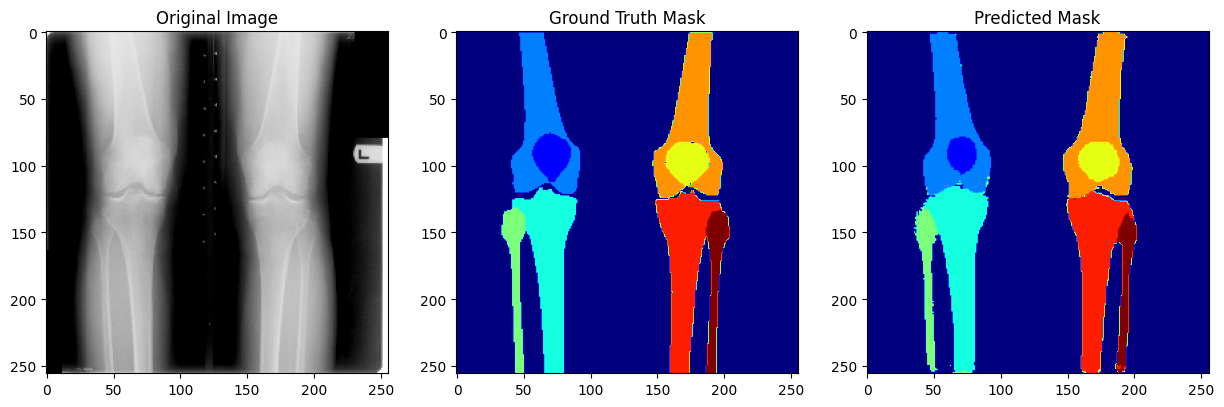

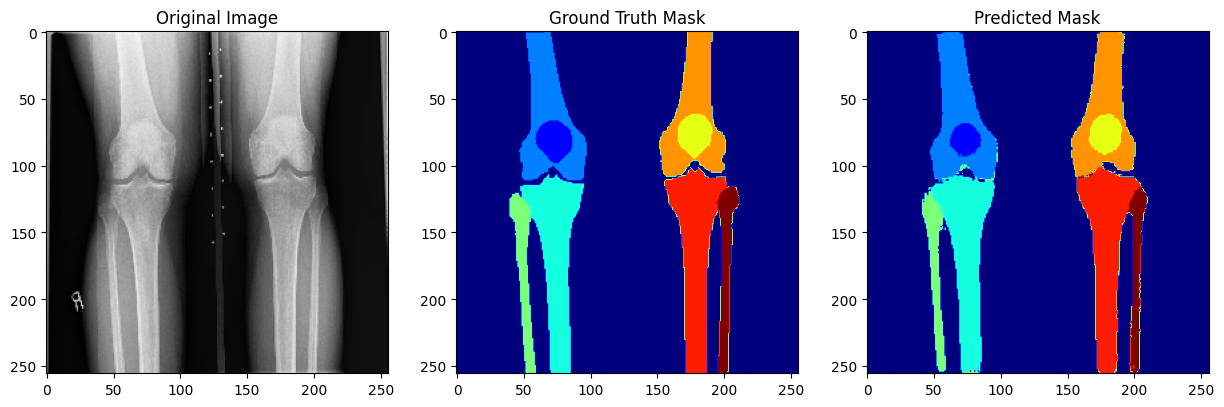

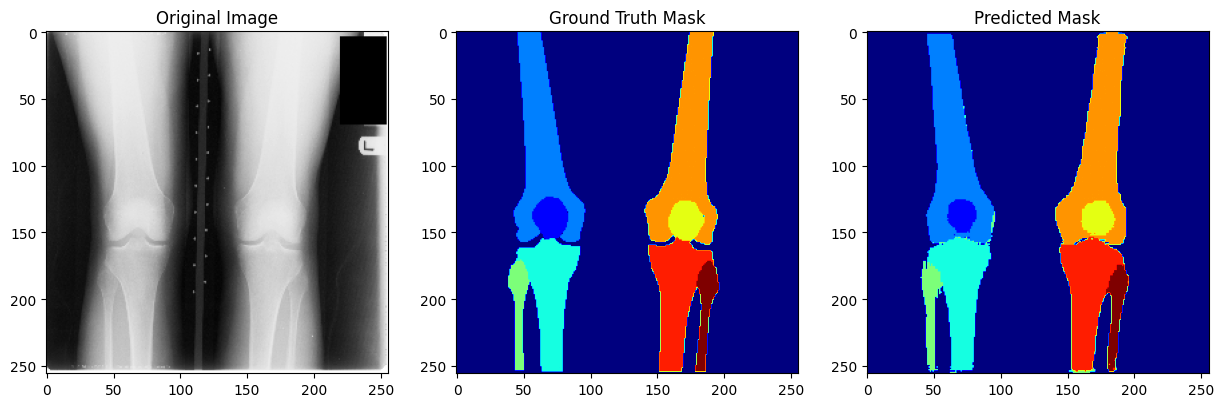

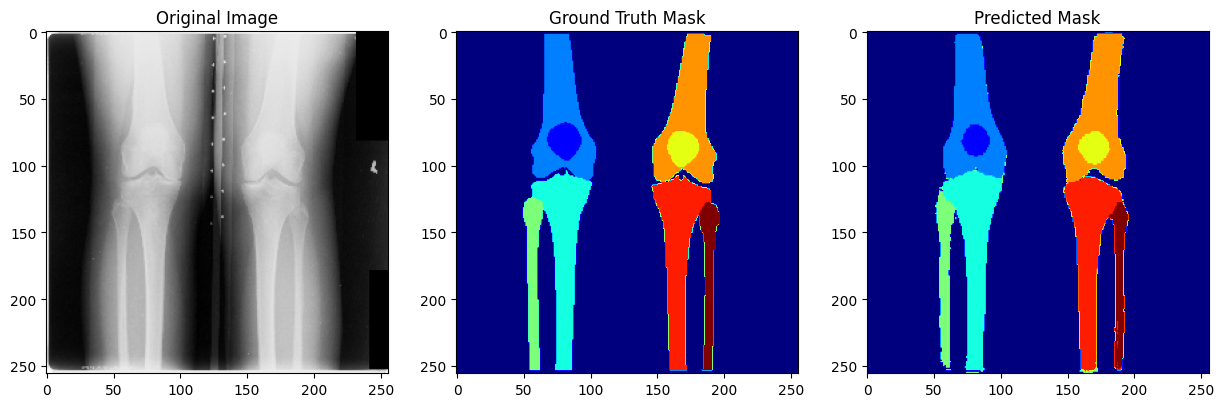

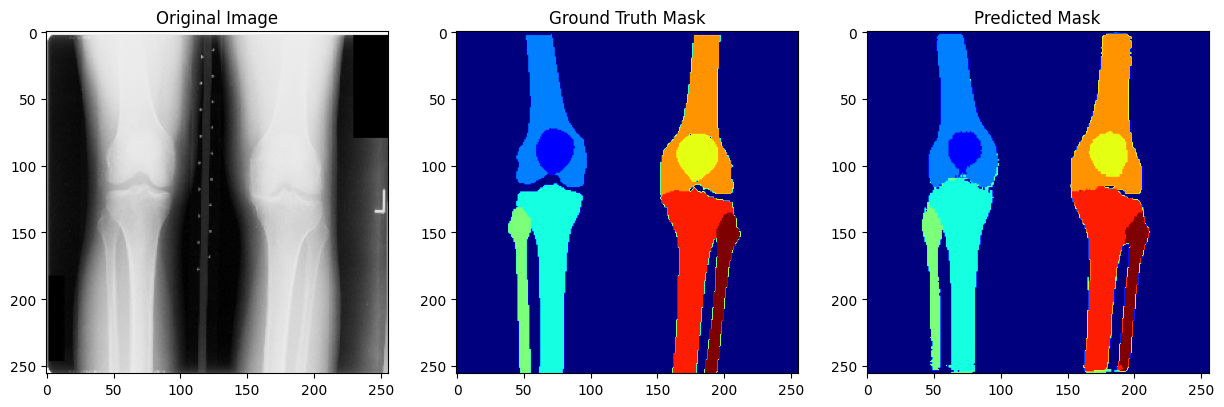

In [ ]:
import matplotlib.pyplot as plt
import torch

# Set the student model to evaluation mode
student_model.eval()

# Select 5 random samples from the train_loader
sample_indices = np.random.choice(len(train_loader.dataset), 5, replace=False)

# Iterate over the selected samples
for idx in sample_indices:
    # Get the image and mask data from the train_loader
    image, annotation_data_onehot = train_loader.dataset[idx]

    # Add batch dimension
    image = image.unsqueeze(0).to(device)

    # Predict with the student model
    with torch.no_grad():
        output = student_model(image)
        predicted_mask = torch.argmax(output, dim=1).cpu().numpy()[0]

    # Reverse one-hot encoding for ground truth mask
    ground_truth_mask = np.argmax(annotation_data_onehot, axis=0)

    # Plot the results
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(image.squeeze().cpu().numpy(), cmap='gray')
    axs[0].set_title('Original Image')
    axs[1].imshow(ground_truth_mask, cmap='jet', vmin=0, vmax=num_classes - 1)
    axs[1].set_title('Ground Truth Mask')
    axs[2].imshow(predicted_mask, cmap='jet', vmin=0, vmax=num_classes - 1)
    axs[2].set_title('Predicted Mask')
    plt.show()
